## Clustering Statistics

This notebook demonstrates how to calculate the 2-point clustering statistics from DESI data. To generate the window power spectrum, the following are required:
- Number of random mocks: ELG: 10; LRG: 8 ;QSO: 4 (clustering.ran.fits)
- One data file. (clustering.dat.fits)

This notebook also provides how to train the emulators and use the profiler. 

The power spectrum is calculated with`compute_pk.sh`, using the `cosmodesi` environment and the `pkrun.py` to compute the power spectrum.

In [66]:
# loading the desilike enviroment
import os
import glob
import numpy as np
from matplotlib import pyplot as plt

from cosmoprimo.fiducial import DESI
from desilike.theories.galaxy_clustering import DirectPowerSpectrumTemplate, ShapeFitPowerSpectrumTemplate, StandardPowerSpectrumTemplate
from desilike.theories.galaxy_clustering import FOLPSTracerPowerSpectrumMultipoles, FOLPSRCTracerPowerSpectrumMultipoles
from desilike.observables.galaxy_clustering import TracerPowerSpectrumMultipolesObservable
from desilike.likelihoods import ObservablesGaussianLikelihood
from desilike import plotting
from desilike import setup_logging
setup_logging()

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 14
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [67]:
# vairables for pk calculation
tracer = "ELG_LOPnotqso" 
ran_mock_num = "10" # ELG:10; LRG:8; QSO:4
region = "NGC"  # NGC or SGC
mocks_fn = os.path.join(os.environ['SCRATCH'], "mocks/")
pk_dir = os.path.join(os.environ['HOME'], "project_rc/main/data/pk/")
pk_run = os.path.join(os.environ['HOME'], "project_rc/main/desihub/pkrun.py")

# load the pk file, the pk calculated from the pkrun.py
pk_fn = pk_dir+f'pkpoles_{tracer}_{region}_0.8_1.1_default_FKP_lin_thetacut0.05.npy'
# load the covariance matrix from the Ezmocks
cov_dir = '/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/'
cov_fn = f'pkpoles_ELG_LOP_{region}_z0.8-1.1_default_FKP_lin_nran10_cellsize6_boxsize9000.npy'

cov_fns = []
for i in range(100, 200):
    mock_dir = f'mock{i}/pk/'
    cov_fns.extend(glob.glob(os.path.join(cov_dir,  mock_dir, cov_fn), recursive=True))

In [68]:
# set the k bins
kmin     = 0.005
kmax     = 0.205
binning  = 0.005
k_ev     = np.arange(kmin, kmax, binning)
klen     = len(k_ev)
klim     = {ell*2: (kmin,kmax,binning) for ell in range(2)}

cosmo = DESI()
template = DirectPowerSpectrumTemplate(fiducial='DESI')
theory = FOLPSRCTracerPowerSpectrumMultipoles(template=template)
print(theory.varied_params)
# footprint = BoxFootprint(volume=1e10, nbar=1e-3)
# covariance = ObservablesCovarianceMatrix(cov_fns, footprints=footprint)()
observable = TracerPowerSpectrumMultipolesObservable(data= pk_fn, 
                                                     klim=klim, 
                                                     covariance = cov_fns,
                                                     theory=theory)
likelihood = ObservablesGaussianLikelihood(observable)
likelihood()


ParameterCollection(['h', 'omega_cdm', 'omega_b', 'logA', 'b1', 'b2', 'bs', 'alpha0', 'alpha2', 'alpha4', 'sn0', 'sn2', 'fc'])
[000003.05] [0/1] 10-21 01:05  TracerPowerSpectrumMultipolesObservable INFO     Loading 1 file ['/global/homes/s/shengyu/project_rc/main/data/pk/pkpoles_ELG_LOPnotqso_NGC_0.8_1.1_default_FKP_lin_thetacut0.05.npy'].
[000003.07] [0/1] 10-21 01:05  TracerPowerSpectrumMultipolesObservable INFO     Loading 100 files [/global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock100/pk/pkpoles_ELG_LOP_NGC_z0.8-1.1_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..., /global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock120/pk/pkpoles_ELG_LOP_NGC_z0.8-1.1_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..., /global/cfs/cdirs/desi/survey/catalogs/Y1/mocks/SecondGenMocks/EZmock/desipipe/v1/ffa/2pt/mock140/pk/pkpoles_ELG_LOP_NGC_z0.8-1.1_default_FKP_lin_nran10_cellsize6_boxsize9000.npy, ..., /glo

Array(-1581.82964432, dtype=float64)

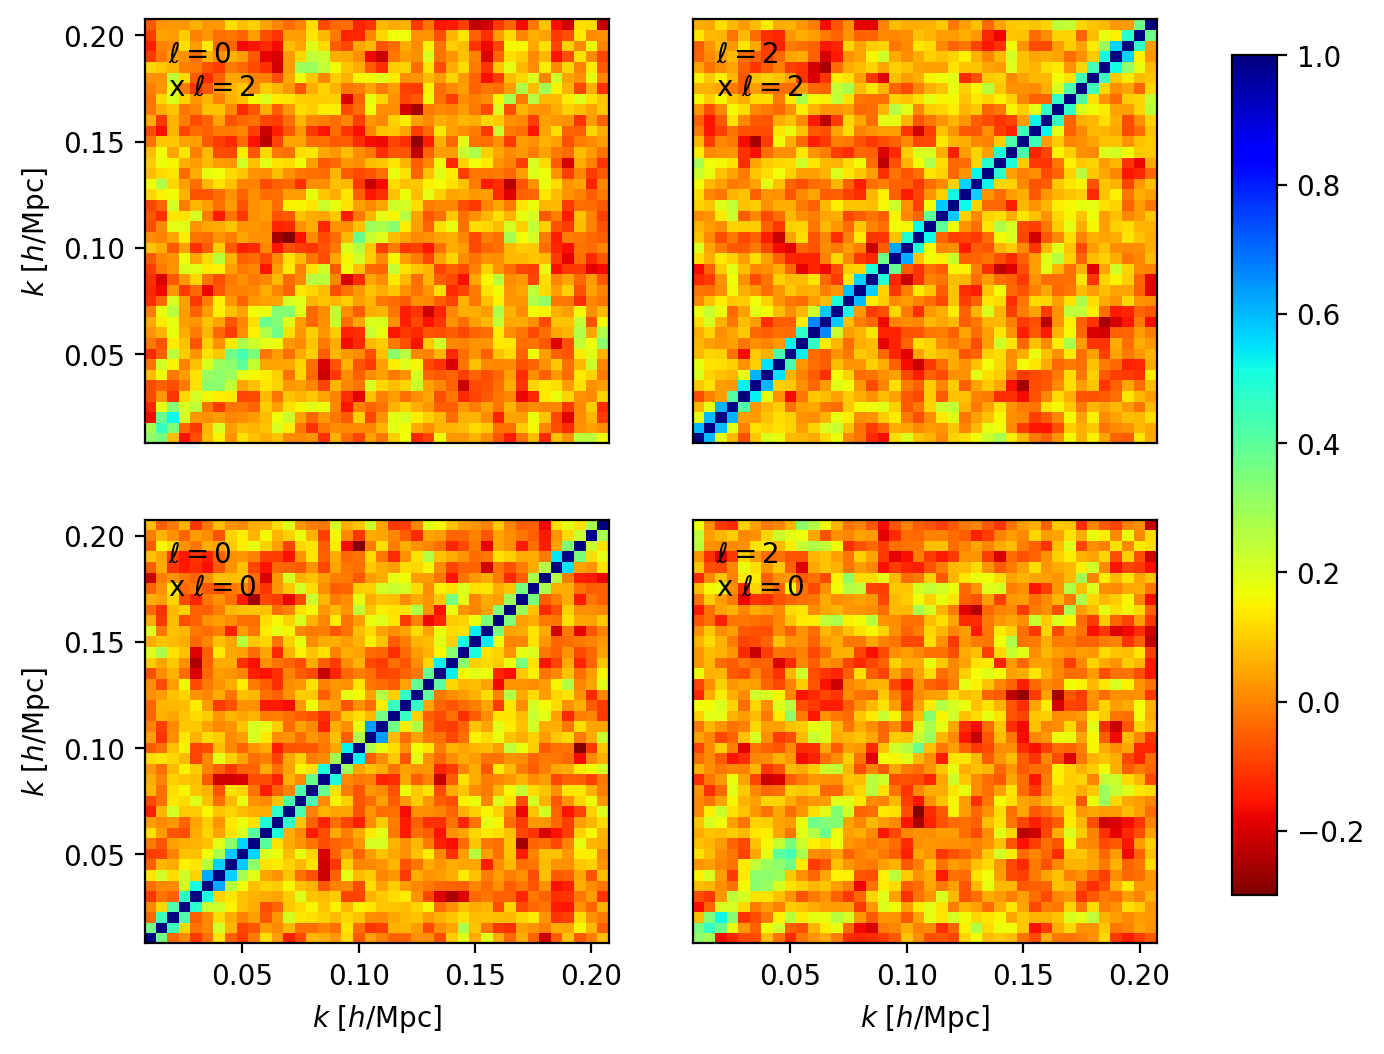

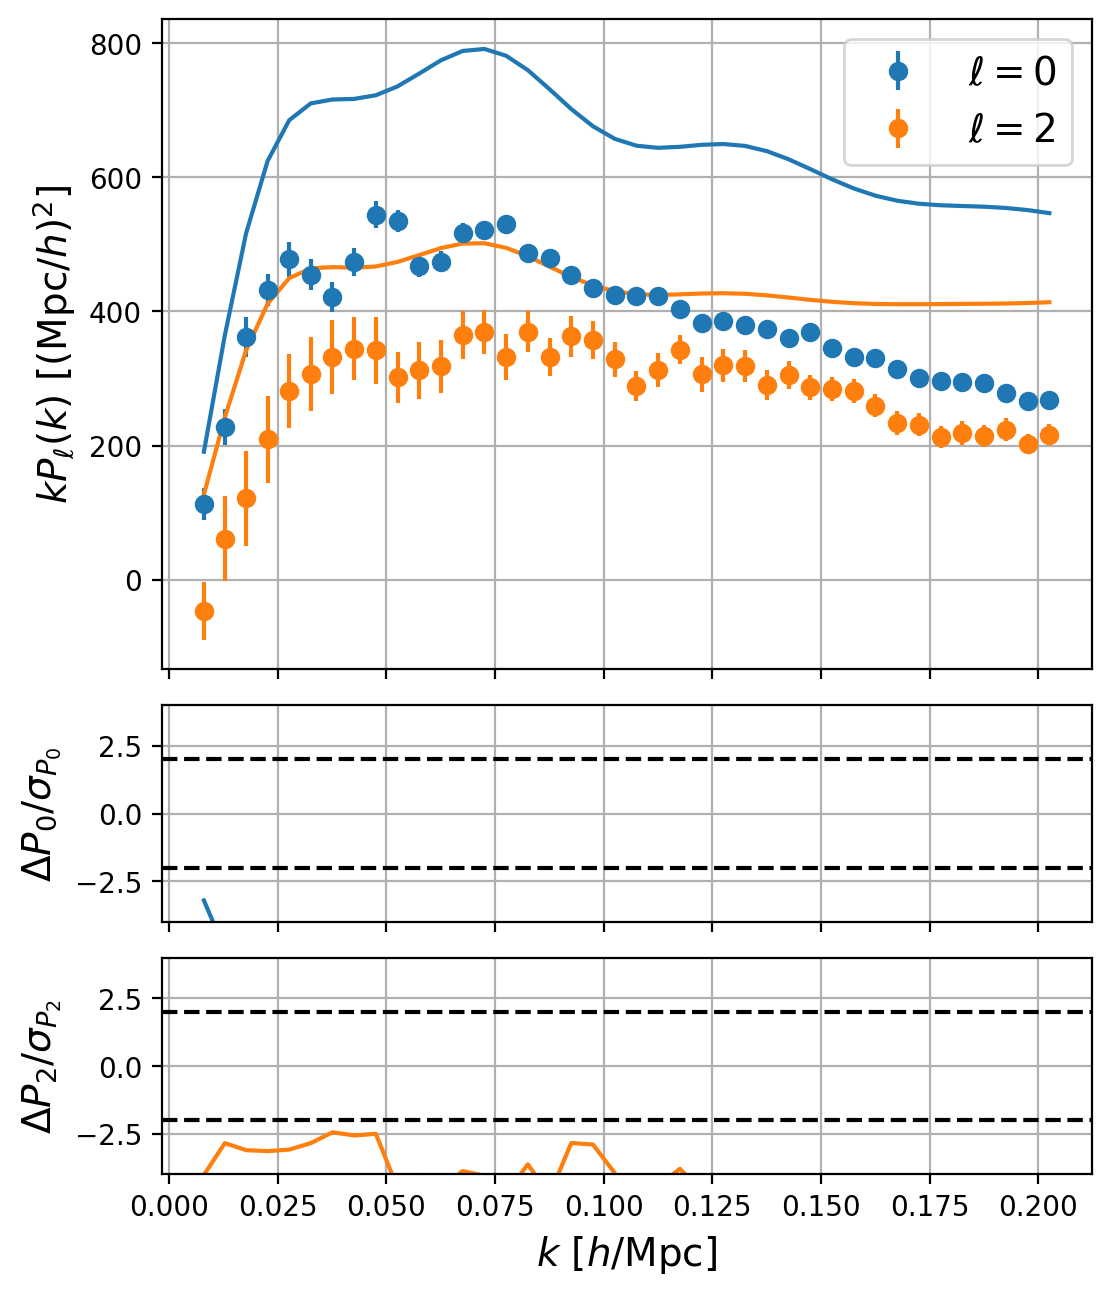

In [69]:
fig_cov = observable.plot_covariance_matrix()
fig_pk = observable.plot()

In [70]:
from desilike.emulators import EmulatedCalculator, Emulator, TaylorEmulatorEngine

redshift = 1.0
cosmology = 'LCDM' #LCDM, nuCDM, wCDM
theory_model = 'FOLPS'  # TNS, FOLPS, FOLPSRC
emulator_fn = f'./results/emulators/emulator_{cosmology}_{theory_model}.npy'

def initialize_template(redshift, cosmology):
    cosmo = DESI()
    template = DirectPowerSpectrumTemplate(z=redshift, fiducial='DESI')
    if cosmology == 'nuCDM':
        template.init.params['m_ncdm'].update(fixed=False, latex=r'M_\nu', prior = {'limits': [0.0,1.0]})
    elif cosmology == 'nsCDM':
        template.init.params['n_s'].update(fixed=False)
    elif cosmology == 'wCDM':
        template.init.params['w0_fld'].update(fixed=False)
    return template

if not os.path.exists(emulator_fn):
    cosmo = DESI()
    template = initialize_template(redshift, cosmology)
    if theory_model =='FOLPS':
        theory = FOLPSTracerPowerSpectrumMultipoles(template=template, k=k_ev)
    elif theory_model =='FOLPSRC':
        theory = FOLPSRCTracerPowerSpectrumMultipoles(template=template, k=k_ev)
    print(theory.varied_params)
    # footprint = BoxFootprint(volume=1e10, nbar=1e-3)
    # covariance = ObservablesCovarianceMatrix(cov_fns, footprints=footprint)()
    observable = TracerPowerSpectrumMultipolesObservable(data= pk_fn, 
                                                        klim=klim, 
                                                        covariance = cov_fns,
                                                        theory = theory)
    likelihood = ObservablesGaussianLikelihood(observable)
    likelihood()
    emulator = Emulator(theory.pt, engine=TaylorEmulatorEngine(order=3, method='finite')) # Taylor expansion, up to a given order
    emulator.set_samples() # evaluate the theory derivatives (with jax auto-differentiation if possible, else finite differentiation)
    emulator.fit()
    emulator.save(emulator_fn)
    print("Training emmulator finished")

In [71]:
theory_el = FOLPSTracerPowerSpectrumMultipoles(pt=EmulatedCalculator.load(emulator_fn), k=k_ev)
print(theory_el(h = 0.7))

[000015.58] [0/1] 10-21 01:06  Emulator                  INFO     Loading ./results/emulators/emulator_LCDM_FOLPS.npy.
[[25053.23992688 29766.04070119 30377.04923005 28537.38297081
  25551.62452596 22364.24534799 19526.23204369 17266.68527128
  15605.56093623 14418.85794901 13528.22734365 12764.81620136
  11998.86768853 11163.79869286 10258.94723103  9330.58749977
   8444.96410688  7663.98100697  7020.73807646  6522.213561
   6149.00254149  5868.78624654  5642.07280823  5432.83811104
   5214.81060504  4975.00577366  4715.3624802   4447.85799365
   4188.43434559  3951.03036094  3745.13076495  3573.57792187
   3432.47766381  3315.35406654  3213.9371113   3120.03522302
   3027.57193148  2932.71236065  2835.03687006  2736.4443901 ]
 [16359.52369087 19462.62337017 19878.08557167 18680.03673943
  16720.03007883 14615.8598374  12729.41235709 11213.54267412
  10085.0392278   9267.60099419  8651.08059732  8132.55292651
   7632.79874999  7109.42322646  6558.39911572  6002.31541551
   5475.212672

In [132]:
from desilike.profilers import MinuitProfiler
from desilike.samples import Profiles

profile_fn = f'./results/profiles/{cosmology}/profiles_{tracer}_{region}_z{redshift}.npy'    
if not os.path.exists(profile_fn):
    observable = TracerPowerSpectrumMultipolesObservable(data= pk_fn, 
                                                        klim=klim, 
                                                        covariance = cov_fns,
                                                        theory=theory_el)
    likelihood = ObservablesGaussianLikelihood(observable, theory=theory_el)
    likelihood() 
    profiler = MinuitProfiler(likelihood, seed=42)
    profiles = profiler.maximize()
    profiles.save(profile_fn)
    print("Profiler finished")
profiles = Profiles.load(profile_fn)
print(profiles.to_stats(tablefmt='pretty'))


[001372.34] [0/1] 10-21 01:28  Profiles                  INFO     Loading ./results/profiles/LCDM/profiles_ELG_LOPnotqso_NGC_z1.0.npy.
+--------------------------------------+--------+---------+--------+
| chi2 / (80 - 11) = 21.90 / 69 = 0.32 | varied | bestfit | error  |
+--------------------------------------+--------+---------+--------+
|                  h                   |  True  |  0.788  | 0.025  |
|              omega_cdm               |  True  | 0.0968  | 0.0081 |
|               omega_b                |  True  | 0.02234 | 3.7e-4 |
|                 logA                 |  True  |  2.032  | 0.079  |
|                  b1                  |  True  |  2.11   |  0.18  |
|                  b2                  |  True  |   3.7   |  1.7   |
|                  bs                  |  True  |  -21.0  |  6.9   |
|                alpha0                |  True  |  -420   |  190   |
|                alpha2                |  True  |   400   |  150   |
|                 sn0                

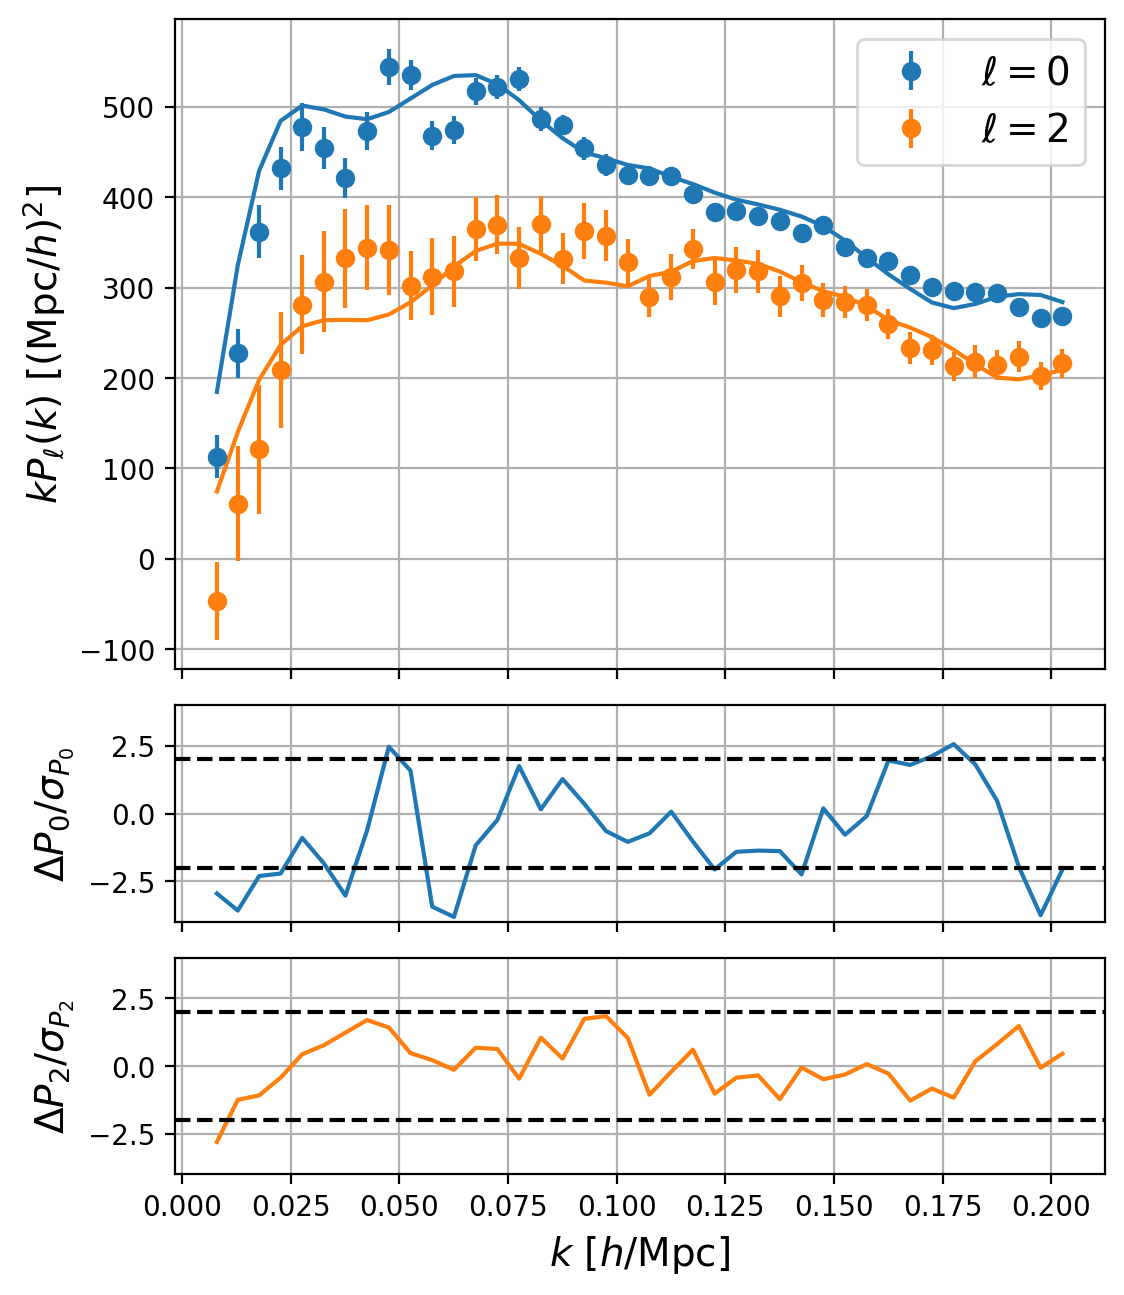

In [133]:
# plot the best-fit pk from the profiles
likelihood(**profiles.bestfit.choice(input=True))
fig = observable.plot()

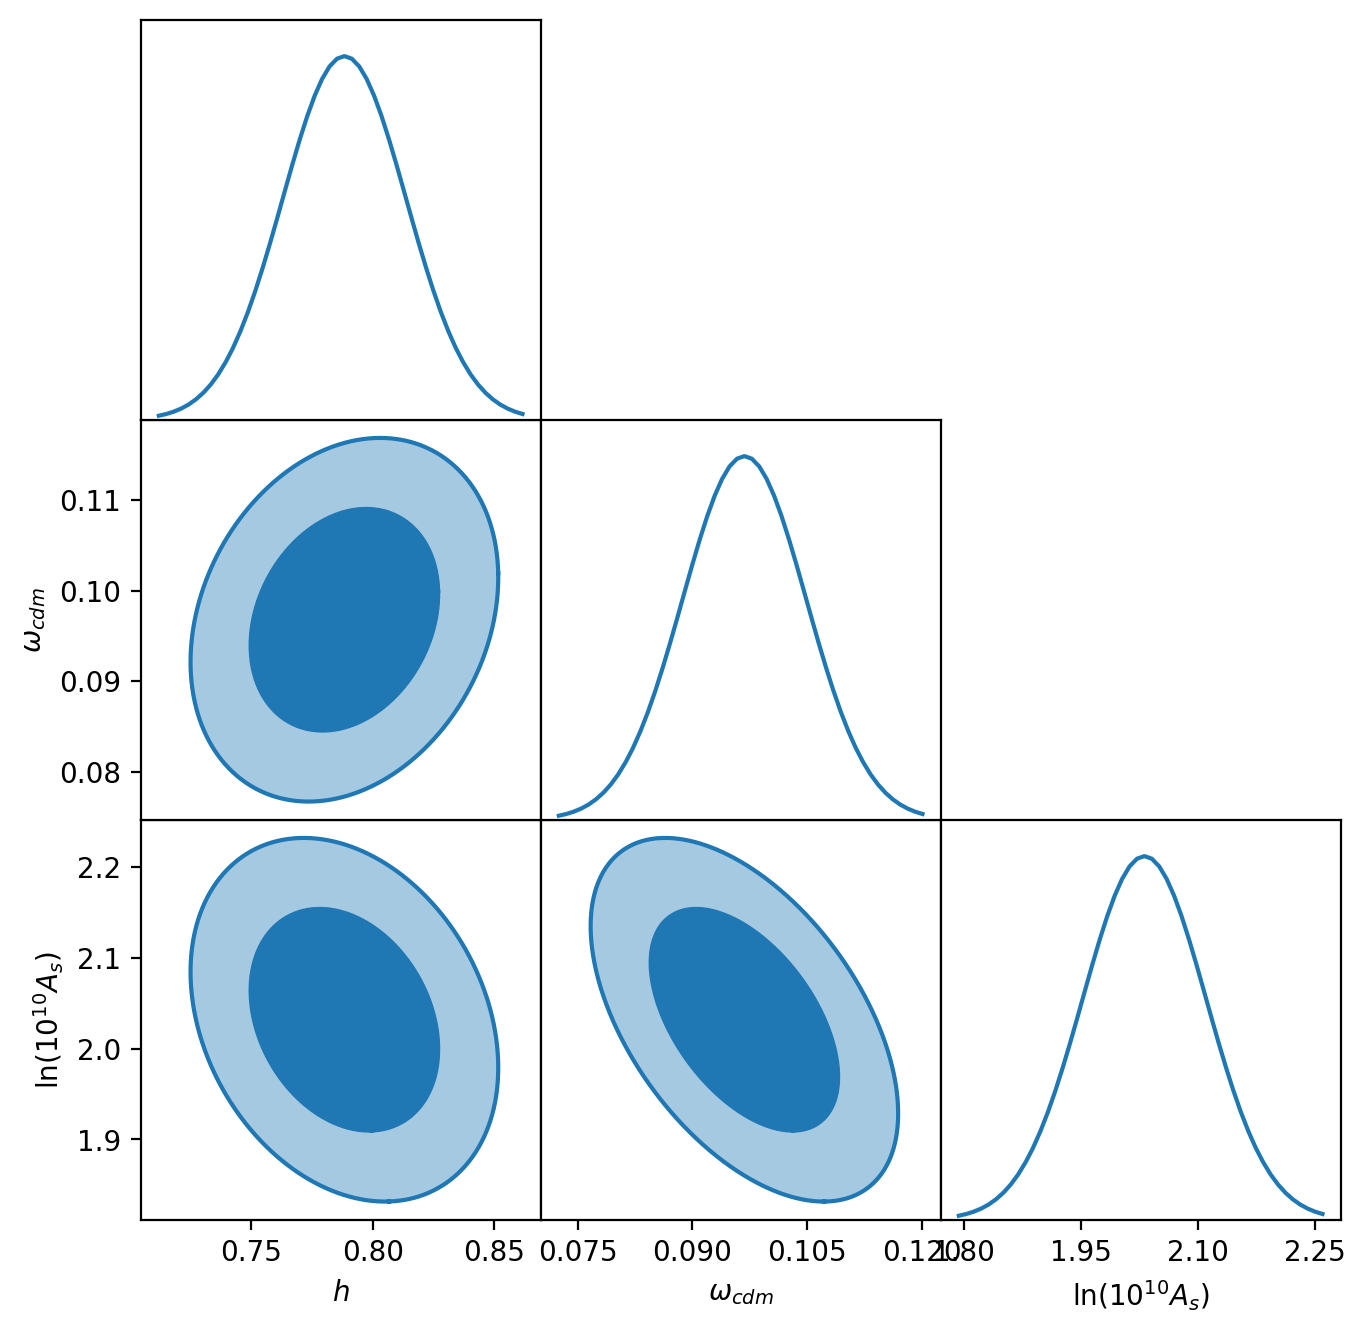

In [136]:
# plot the posterior distribution
from desilike.samples import plotting
fig =plotting.plot_triangle_contours(profiles, params=['h','omega_cdm','logA'], filled=True)
